In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

import bars
import c
import signals
import u

# Data Generation

<AxesSubplot:>

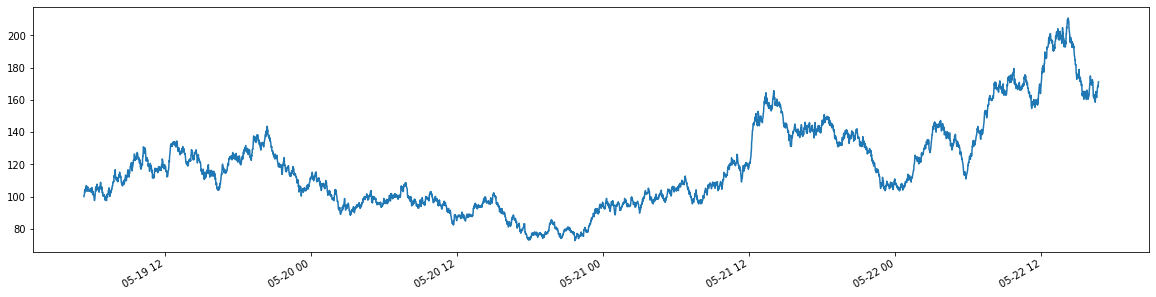

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=5000)
data["close"].plot.line()

# Triple Barrier

In [4]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std())
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(3, "h")

target

0.0766786968666374

<AxesSubplot:>

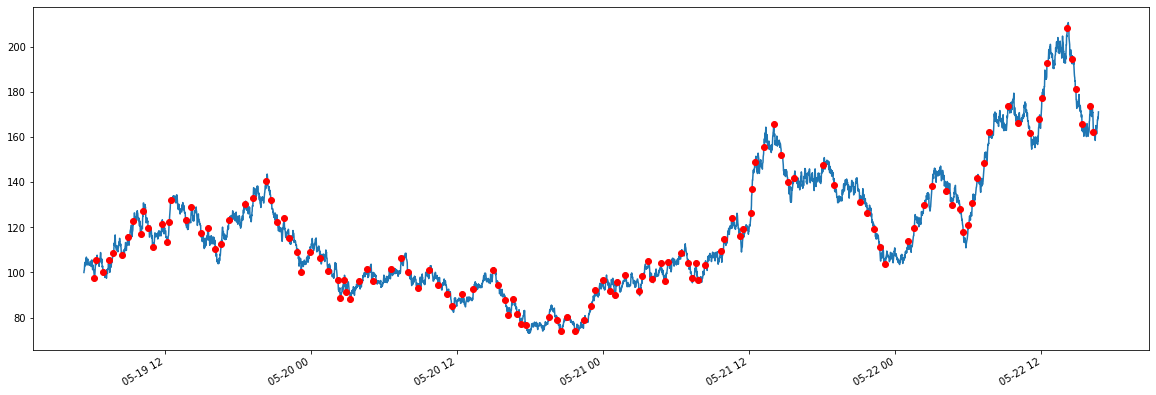

In [5]:
cusum_indices = signals.get_cusum_indices(data["close"], target)

plt.rcParams["figure.figsize"] = (20, 7)

data["close"].plot.line()
(data["close"] * cusum_indices).replace(0, np.nan).plot(style="o", color="r")

In [6]:
indices = data.index[cusum_indices]

In [7]:
barriers = signals.get_price_target_stop_loss_indices(
    data, indices, target=target, price_target=price_target, stop_loss=stop_loss, vertical_barrier=vertical_barrier
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head(10)

,pt_dt,sl_dt,pt_sl
2022-05-19 06:12:54.774231,2022-05-19 06:19:54.774231,NaT,1
2022-05-19 06:19:54.774231,2022-05-19 07:53:54.774231,2022-05-19 07:12:54.774231,-1
2022-05-19 06:56:54.774231,2022-05-19 07:43:54.774231,NaT,1
2022-05-19 07:25:54.774231,2022-05-19 07:53:54.774231,NaT,1
2022-05-19 07:44:54.774231,2022-05-19 09:09:54.774231,NaT,1
2022-05-19 08:27:54.774231,2022-05-19 08:58:54.774231,NaT,1
2022-05-19 08:57:54.774231,2022-05-19 09:29:54.774231,NaT,1
2022-05-19 09:25:54.774231,NaT,2022-05-19 10:59:54.774231,-1
2022-05-19 10:01:54.774231,2022-05-19 10:13:54.774231,NaT,1
2022-05-19 10:13:54.774231,NaT,2022-05-19 10:44:54.774231,-1


In [8]:
last = barriers.index[0]
plot_indices = [last]
for i in barriers.index:
    if last + vertical_barrier < i:
        plot_indices.append(i)
        last = i

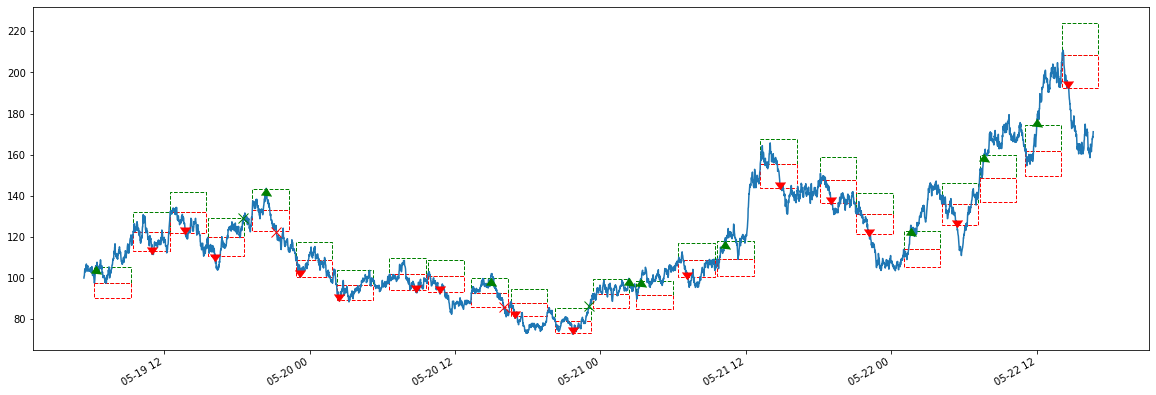

In [9]:
import plt_utils

fig, ax = plt.subplots()
data["close"].plot.line()

plt_utils.plot_triple_barrier(
    ax,
    data,
    barriers.loc[plot_indices],
    target=target,
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)